# Вопрос 1 Импортируем библиотеки и загружаем данные

In [18]:
import pandas as pd

data = pd.read_csv('data/bank-full.csv', sep=';')
# Вычисляем моду
education_mode = data['education'].mode()[0]

print("Самое частое значение в 'education':", education_mode)

Самое частое значение в 'education': secondary


# Вопрос 2 Вычисляем корреляционную матрицу

In [19]:

# Выбор только числовых признаков
numeric_data = data[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]
correlation_matrix = numeric_data.corr()

# Нахождение пары признаков с наибольшей корреляцией
max_corr = correlation_matrix.unstack().sort_values(ascending=False)
print("Наибольшая корреляция:\n", max_corr)


Наибольшая корреляция:
 age       age         1.000000
balance   balance     1.000000
day       day         1.000000
campaign  campaign    1.000000
duration  duration    1.000000
pdays     pdays       1.000000
previous  previous    1.000000
pdays     previous    0.454820
previous  pdays       0.454820
day       campaign    0.162490
campaign  day         0.162490
balance   age         0.097783
age       balance     0.097783
balance   duration    0.021560
duration  balance     0.021560
previous  balance     0.016674
balance   previous    0.016674
campaign  age         0.004760
age       campaign    0.004760
balance   day         0.004503
day       balance     0.004503
balance   pdays       0.003435
pdays     balance     0.003435
previous  age         0.001288
age       previous    0.001288
duration  previous    0.001203
previous  duration    0.001203
pdays     duration   -0.001565
duration  pdays      -0.001565
age       duration   -0.004648
duration  age        -0.004648
age       day  

# Вопрос 3 Вычисление взаимной информации

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Выбор необходимых признаков
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 
            'contact', 'day', 'month', 'duration', 'campaign', 
            'pdays', 'previous', 'poutcome']
X = data[features]
y = data['y'].map({'yes': 1, 'no': 0})  # Кодирование целевой переменной

# Применение one-hot кодирования к категориальным переменным
X_encoded = pd.get_dummies(X, drop_first=True)

# Разделение данных на тренировочный и тестовый наборы
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Вычисление взаимной информации
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True)
mi_scores_series = pd.Series(mi_scores, index=X_train.columns)
print("Взаимная информация:\n", mi_scores_series.round(2))


Взаимная информация:
 age                    0.01
balance                0.10
day                    0.01
duration               0.10
campaign               0.00
pdays                  0.03
previous               0.01
job_blue-collar        0.00
job_entrepreneur       0.00
job_housemaid          0.00
job_management         0.00
job_retired            0.00
job_self-employed      0.00
job_services           0.00
job_student            0.00
job_technician         0.00
job_unemployed         0.00
job_unknown            0.00
marital_married        0.00
marital_single         0.00
education_secondary    0.00
education_tertiary     0.00
education_unknown      0.00
housing_yes            0.01
contact_telephone      0.00
contact_unknown        0.01
month_aug              0.00
month_dec              0.00
month_feb              0.00
month_jan              0.00
month_jul              0.00
month_jun              0.00
month_mar              0.01
month_may              0.01
month_nov              0.0

# Вопрос 4 Обучение логистической регрессии и расчет точности

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

accuracy = accuracy_score(y_val, model.predict(X_val))
print("Точность на валидационном наборе:", round(accuracy, 2))


Точность на валидационном наборе: 0.9


# Вопрос 5 Оценка важности каждого признака

In [22]:
# Исходная точность модели
base_accuracy = accuracy_score(y_val, model.predict(X_val))
print("Точность модели со всеми признаками:", round(base_accuracy, 4))

# Список признаков для оценки
features_to_test = ['age', 'balance', 'marital', 'previous']

# Словарь для хранения разницы
feature_importance_diff = {}

# Оценка важности каждого признака
for feature in features_to_test:
    # Найдем все столбцы после one-hot кодирования
    feature_columns = [col for col in X_train.columns if feature in col]
    
    # Исключаем признак(и) из данных
    X_train_temp = X_train.drop(columns=feature_columns)
    X_val_temp = X_val.drop(columns=feature_columns)

    # Обучение модели на данных без одного признака
    model_temp = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_temp.fit(X_train_temp, y_train)
    
    # Вычисление точности на наборе
    accuracy_temp = accuracy_score(y_val, model_temp.predict(X_val_temp))
    
    # Разница в точности
    diff = base_accuracy - accuracy_temp
    feature_importance_diff[feature] = round(diff, 4)
    print(f"Точность без признака {feature}: {round(accuracy_temp, 4)}, Разница: {round(diff, 4)}")

# Нахождение признака с наименьшей разницей
least_important_feature = min(feature_importance_diff, key=feature_importance_diff.get)
print(f"Наименее важный признак: {least_important_feature}, Разница: {feature_importance_diff[least_important_feature]}")


Точность модели со всеми признаками: 0.8987
Точность без признака age: 0.8994, Разница: -0.0007
Точность без признака balance: 0.8994, Разница: -0.0007
Точность без признака marital: 0.8989, Разница: -0.0002
Точность без признака previous: 0.8995, Разница: -0.0008
Наименее важный признак: previous, Разница: -0.0008


# Вопрос 6

Точность при C=0.01: 0.8966
Точность при C=0.1: 0.8989
Точность при C=1: 0.8987
Точность при C=10: 0.899
Точность при C=100: 0.8996
Наилучшее значение C: 100


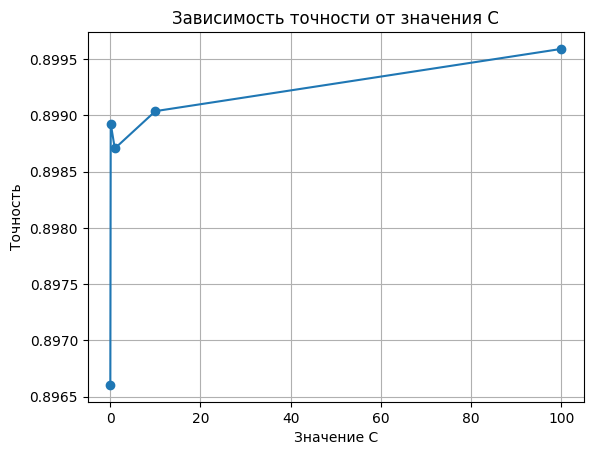

In [23]:
import matplotlib.pyplot as plt

# Значения C для тестирования
C_values = [0.01, 0.1, 1, 10, 100]
best_accuracy = 0
best_C = 0
accuracies = []

# Перебираем значения
for C in C_values:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_val, model.predict(X_val))
    accuracies.append(accuracy)  # Сохраняем точность для каждого C
    print(f"Точность при C={C}: {round(accuracy, 4)}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

print("Наилучшее значение C:", best_C)

# Визуализируем зависимости точности от C
plt.plot(C_values, accuracies, marker='o')
plt.xlabel('Значение C')
plt.ylabel('Точность')
plt.title('Зависимость точности от значения C')
plt.grid(True)
plt.show()
